In [45]:
#필요한 라이브러리
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [46]:
# Load Data
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [47]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [50]:
class diabetesDense(nn.Module):
    def __init__(self):
        super(diabetesDense, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # 출력 크기 1
            nn.Sigmoid() 
        )

    def forward(self, x):
        return self.model(x)

model = diabetesDense()

In [51]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [53]:
import torch

# 변수 초기화
train_losses = []
test_accuracies = []

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # 데이터를 GPU로 이동 및 dtype 변환
        labels = labels.view(-1, 1)  # BCEWithLogitsLoss를 사용할 경우 labels 크기 맞추기

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            labels = labels.view(-1, 1)

            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()  # 이진 분류에서는 0.5 기준으로 예측값 결정
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 0.6550, Accuracy: 74.03%
Epoch 2/30, Loss: 0.6052, Accuracy: 76.62%
Epoch 3/30, Loss: 0.5685, Accuracy: 77.27%
Epoch 4/30, Loss: 0.5244, Accuracy: 76.62%
Epoch 5/30, Loss: 0.5024, Accuracy: 77.27%
Epoch 6/30, Loss: 0.4917, Accuracy: 79.87%
Epoch 7/30, Loss: 0.4902, Accuracy: 77.92%
Epoch 8/30, Loss: 0.4628, Accuracy: 78.57%
Epoch 9/30, Loss: 0.4537, Accuracy: 79.87%
Epoch 10/30, Loss: 0.4542, Accuracy: 79.87%
Epoch 11/30, Loss: 0.4719, Accuracy: 79.87%
Epoch 12/30, Loss: 0.4588, Accuracy: 79.87%
Epoch 13/30, Loss: 0.4458, Accuracy: 79.87%
Epoch 14/30, Loss: 0.4432, Accuracy: 79.87%
Epoch 15/30, Loss: 0.4540, Accuracy: 79.22%
Epoch 16/30, Loss: 0.4433, Accuracy: 79.22%
Epoch 17/30, Loss: 0.4309, Accuracy: 80.52%
Epoch 18/30, Loss: 0.4385, Accuracy: 80.52%
Epoch 19/30, Loss: 0.4416, Accuracy: 81.82%
Epoch 20/30, Loss: 0.4311, Accuracy: 81.82%
Epoch 21/30, Loss: 0.4208, Accuracy: 81.17%
Epoch 22/30, Loss: 0.4494, Accuracy: 81.82%
Epoch 23/30, Loss: 0.4174, Accuracy: 81.1

In [54]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 모델 평가 모드로 변경
model.eval()

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# 결과 저장
all_labels = []
all_predictions = []

# 평가 데이터 처리
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()  # 데이터 GPU로 이동 및 dtype 변환
        labels = labels.view(-1, 1)  # BCEWithLogitsLoss 사용 시 크기 맞추기

        outputs = model(inputs)

        # 이진 분류일 경우 확률 기준으로 예측
        predicted = (outputs >= 0.5).float()  # 0.5 기준으로 분류

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[94 13]
 [15 32]]
F1 Score: 0.82
Precision: 0.82
Recall: 0.82
Specificity: 0.78


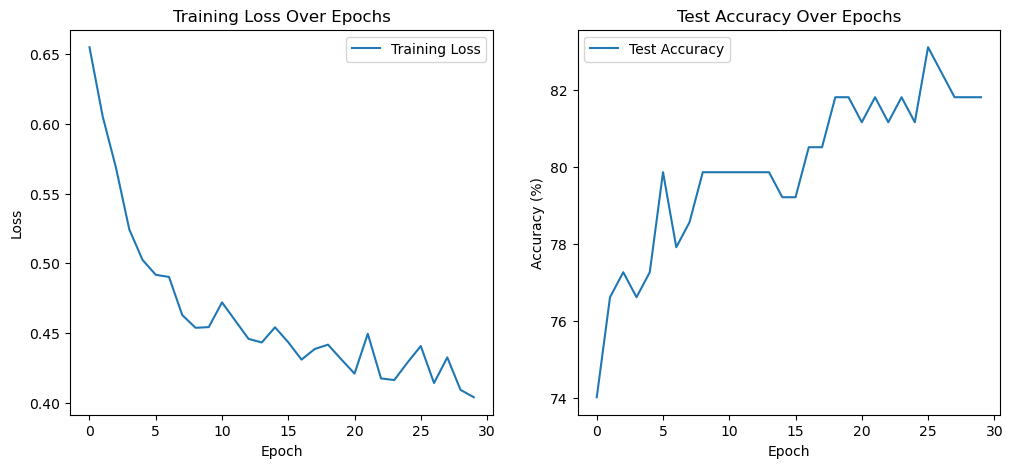

In [55]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()